# Weighted Metric
This notebook explores the effects of a custom metric designed for surface waves based on its cumulative amplitude distribution.

## Imports
This notebook uses the custom code found in the code folder

In [1]:
import os

# math, processing, deep learning
import numpy as np
import tensorflow as tf
from scipy.signal import stft, istft

# visualization
import matplotlib.pyplot as plt
from ipywidgets import interact
from mpl_toolkits.axes_grid1 import make_axes_locatable


# custom code
from code.stftprocessing import StftDataset
from code.dsvisual import DatasetVisualizer

# convenience
from tqdm import tqdm
import datetime


2023-04-25 16:58:26.973866: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Load the files for training and testing
There are different training and test sets in the folder. This section loads the appropriate ones into memory.


In [2]:
# this is a smaller training set for testing purposes
folder = "training/new_small"
base = "noisy_small"
target = "pure_small"

# this is a training set for training the main model
# folder = "training/original training"
# base = "noisy"
# target = "pure"

test_folder = "training/test set"
test_base = "noisy_test"
test_target = "pure_test"


Load the files from the given locations using the custom code StftDataset class.

The StftDataset class also processes the waveforms into STFT format.

In [3]:
noisy_stft = StftDataset()
pure_stft = StftDataset()

noisy_stft.load(folder, base)
pure_stft.load(folder, target)

# test sets
noisy_test_stft = StftDataset()
pure_test_stft = StftDataset()
noisy_test_stft.load(test_folder, test_base)
pure_test_stft.load(test_folder, test_target)

Files loaded.
Files loaded.
Files loaded.
Files loaded.


In [4]:
# get the amplitudes of training and test sets
examples = noisy_stft.get_data()[:,:,:,:]
labels = pure_stft.get_data()[:,:,:,:]

In [5]:
t = noisy_stft.t
f = noisy_stft.f

## Get an example
Get an example from the noisy and clean datasets.

In [6]:
# set index of examples to get
index =0
# get examples from noisy and label set
test_example = examples[index]
label_example = labels[index]

## Process the example
Convert the data into complex-valued data and invert the STFT

In [7]:
# convert the amplitude and phase data into complex valued data
test_example_complex = test_example[:,:,0]*np.exp(1j* test_example[:,:,1])
label_example_complex = label_example[:,:,0]*np.exp(1j* label_example[:,:,1])

In [8]:
# invert the STFT data
t, wave = istft(test_example_complex, fs=5.)
t, wave_pure = istft(label_example_complex, fs=5.)

## Plot
Plot the results.

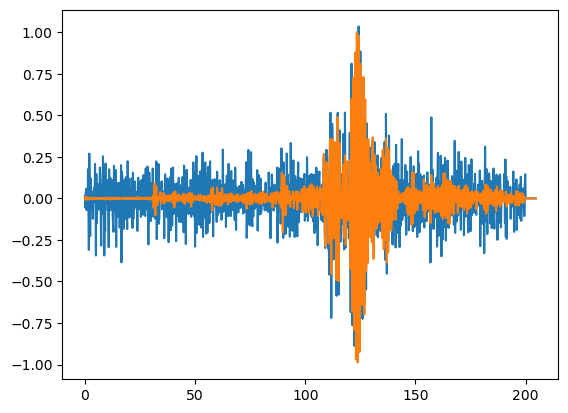

In [9]:
plt.plot(t, wave)
plt.plot(t, wave_pure)

## Analysis of amplitudes
The first approximation of a specialized loss function will be based on the sum of amplitudes across the whole training set.

In [10]:
amplitude = examples[:,:,:,0]

In [14]:
amplitude_mean = np.mean(amplitude, axis=0)

In [15]:
amplitude_mean.shape

(129, 9)

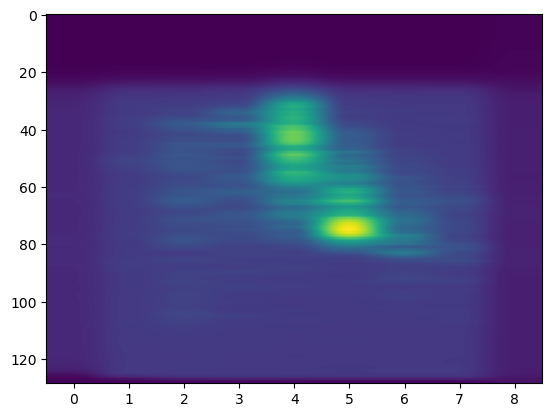

In [17]:
plt.imshow(amplitude_mean, aspect="auto")

In [19]:
np.max(amplitude_mean)

0.05512334015613833

In [20]:
np.min(amplitude_mean)

2.1440929139858448e-07

(array([[ 36.,  93.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 27., 100.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 27.,  49.,  53.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 27.,  52.,  44.,   5.,   1.,   0.,   0.,   0.,   0.,   0.],
        [ 26.,  46.,   9.,  11.,   8.,   6.,  13.,  10.,   0.,   0.],
        [ 27.,  54.,  12.,   8.,   7.,   6.,   6.,   2.,   3.,   4.],
        [ 27.,  62.,  25.,  12.,   3.,   0.,   0.,   0.,   0.,   0.],
        [ 28.,  74.,  27.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [129.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([2.14409291e-07, 5.51252698e-03, 1.10248396e-02, 1.65371521e-02,
        2.20494647e-02, 2.75617773e-02, 3.30740899e-02, 3.85864024e-02,
        4.40987150e-02, 4.96110276e-02, 5.51233402e-02]),
 <a list of 9 BarContainer objects>)

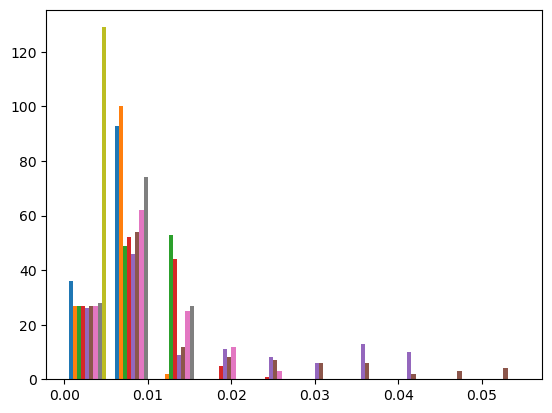

In [21]:
plt.hist(amplitude_mean)

In [ ]:
plt.show()

In [22]:
# filtered_amp_mean = np.where(test_example[:,:,0] > amplitude_threshold,test_example[:,:,0], 0)

In [28]:
quantile_borders = np.quantile(amplitude_mean, [0,0.33,0.66,1])

In [29]:
print(quantile_borders)

[2.14409291e-07 6.27890526e-03 9.85790319e-03 5.51233402e-02]


In [49]:
amplitude_mean = np.mean(amplitude, axis=0)

mid_quantile = np.where(amplitude_mean < quantile_borders[2], amplitude_mean, 0)
mid_quantile = np.where(mid_quantile > quantile_borders[1], amplitude_mean, 0)

low_quantile = np.where(amplitude_mean < quantile_borders[1], amplitude_mean, 0)

high_quantile = np.where(amplitude_mean >quantile_borders[2], amplitude_mean, 0)

(array([[ 60.,   0.,   0.,   0.,   0.,   0.,  69.,   0.,   0.,   0.],
        [ 52.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   2.,  72.],
        [107.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   3.,  18.],
        [ 99.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,  27.],
        [ 94.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,  33.],
        [ 84.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   3.,  41.],
        [ 84.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   3.,  40.],
        [ 69.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   4.,  55.],
        [129.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([0.        , 0.00098562, 0.00197123, 0.00295685, 0.00394246,
        0.00492808, 0.00591369, 0.00689931, 0.00788492, 0.00887054,
        0.00985616]),
 <a list of 9 BarContainer objects>)

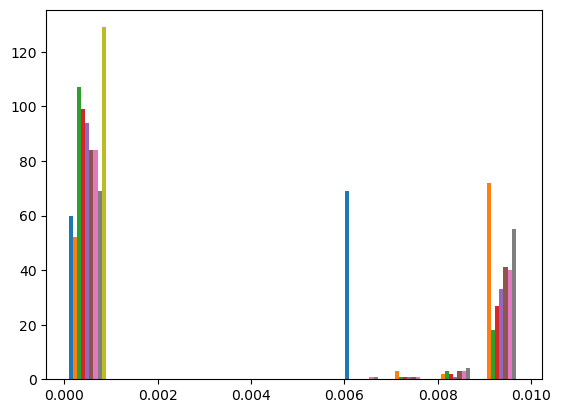

In [50]:
plt.hist(mid_quantile)

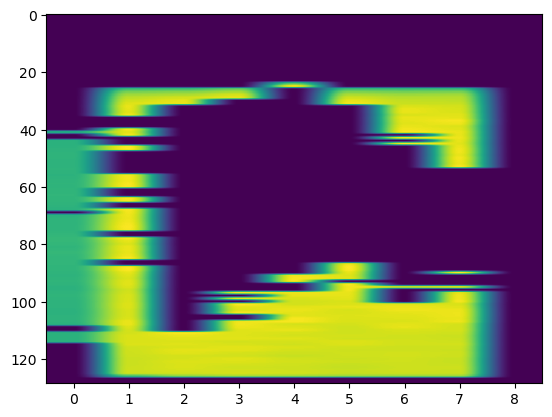

In [51]:
plt.imshow(mid_quantile, aspect="auto")

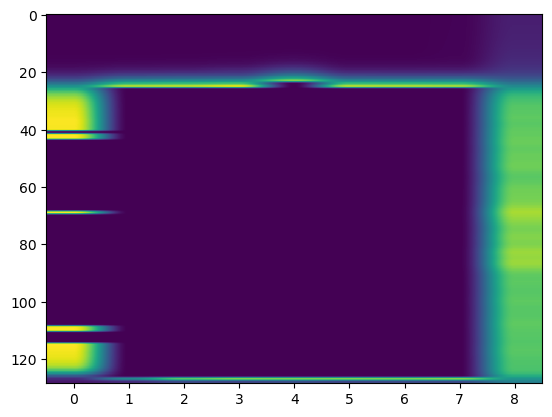

In [52]:
plt.imshow(low_quantile, aspect="auto")

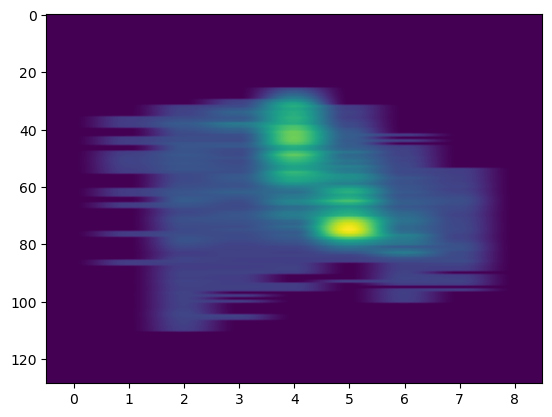

In [53]:
plt.imshow(high_quantile, aspect="auto")

In [54]:
amplitude_var = np.var(amplitude, axis=0)


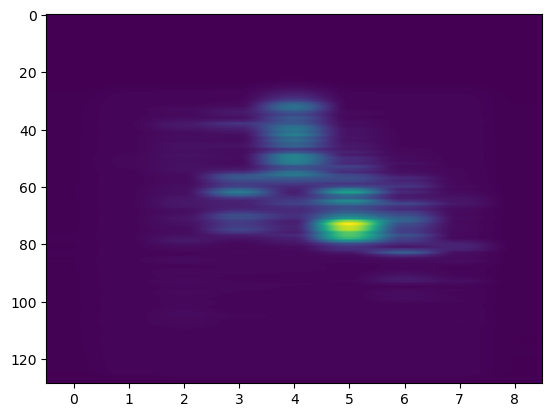

In [56]:
plt.imshow(amplitude_var, aspect="auto")